In [1]:
#hide
# Import time!
from loguru import logger
from rich.logging import RichHandler

# Logging setup
logger.configure(
    handlers=[
        {
            "sink": RichHandler(
                log_time_format="%Y-%m-%d %X",
                rich_tracebacks=True,
                show_path=False,
                tracebacks_width=200,
            ),
            "format": "{message}",
            "level": "DEBUG",
        }
    ]
)

[1]

In [2]:
from pathlib import Path
titanic_data_path = Path('./titanic/')

In [11]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

# Prep the data

In [34]:
df = pd.read_csv(titanic_data_path / 'train.csv')

In [39]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map({
        "A": 'ABC',
        "B": 'ABC',
        "C": 'ABC',
        "D": 'DE',
        "E": 'DE',
        "F": 'FG',
        "G": 'FG',
    })
    df['Family'] = df.SibSp + df.Parch
    df['Alone'] = df.Family == 1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    # df['Title'] = df.Title.map(dict(Mr='Mr', Miss='Miss', Mrs='Mrs', Master='Master')).value_counts(dropna=False)

add_features(df)

In [40]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,True,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,True,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,False,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,True,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,False,1,Mr


In [41]:
splits = RandomSplitter(seed=42)(df)

In [42]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names='Survived', y_block=CategoryBlock(),
).dataloaders(path='.')

In [43]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10, 10])

SuggestedLRs(slide=0.05754399299621582, valley=0.005248074419796467)

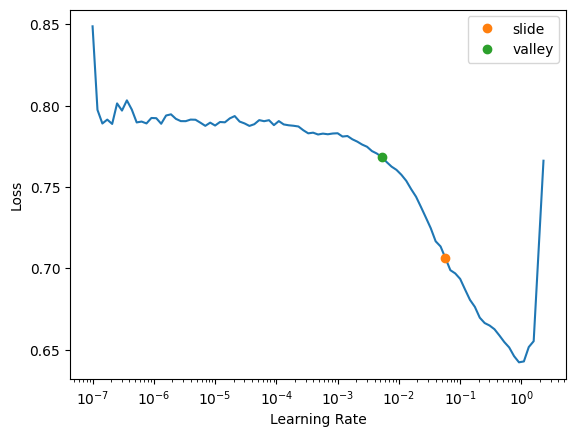

In [44]:
learn.lr_find(suggest_funcs=(slide, valley))

In [45]:
learn.fit(15, lr=0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.641887,0.602764,0.651685,00:00
1,0.537033,0.452083,0.814607,00:00
2,0.486080,0.423884,0.803371,00:00
3,0.457816,0.441239,0.797753,00:00
4,0.452687,0.464083,0.747191,00:00
5,0.447777,0.468672,0.803371,00:00
6,0.442486,0.467475,0.797753,00:00
7,0.434333,0.481801,0.831461,00:00
8,0.426309,0.426294,0.831461,00:00
9,0.417149,0.446013,0.820225,00:00


In [47]:
test_df = pd.read_csv(titanic_data_path / 'test.csv')
test_df['Fare'] = test_df.Fare.fillna(0)
add_features(test_df)

In [48]:
test_dl = learn.dls.test_dl(test_df)

# Ensembling

In [50]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10, 10])
    with learn.no_bar(), learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=test_dl)[0]

In [51]:
learns = [ensemble() for _ in range(5)]

In [52]:
ensemble_predictions = torch.stack(learns).mean(0)
ensemble_predictions

tensor([[0.9101, 0.0899],
        [0.5994, 0.4006],
        [0.9549, 0.0451],
        [0.9184, 0.0816],
        [0.3839, 0.6161],
        [0.8851, 0.1149],
        [0.3742, 0.6258],
        [0.9635, 0.0365],
        [0.1959, 0.8041],
        [0.9387, 0.0613],
        [0.9359, 0.0641],
        [0.9368, 0.0632],
        [0.0361, 0.9639],
        [0.9677, 0.0323],
        [0.0310, 0.9690],
        [0.0205, 0.9795],
        [0.9147, 0.0853],
        [0.8399, 0.1601],
        [0.5529, 0.4471],
        [0.3601, 0.6399],
        [0.9196, 0.0804],
        [0.1747, 0.8253],
        [0.0687, 0.9313],
        [0.8843, 0.1157],
        [0.1796, 0.8204],
        [0.9604, 0.0396],
        [0.0230, 0.9770],
        [0.8465, 0.1535],
        [0.8691, 0.1309],
        [0.9153, 0.0847],
        [0.9603, 0.0397],
        [0.9041, 0.0959],
        [0.5954, 0.4046],
        [0.5530, 0.4470],
        [0.6839, 0.3161],
        [0.8272, 0.1728],
        [0.5464, 0.4536],
        [0.4746, 0.5254],
        [0.9